# Personalised Praise: Retention

This notebook examines whether Personalised Praise has an overall effect on newcomer retention. In this case, we have defined a 30-day window for receiving praise. Because of this, we have then redefined retention to also fall within this 30-day window.

In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)

library(lme4)

library(here)

Warning message:
“package ‘tidyverse’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
Warning message:
“package ‘lubridate’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

Warning message:
“package ‘RhpcBLASctl’ was built under R version 4.2.3”


# Configuration variables

In [109]:
## Wide dataset with editing data, used specifically for this type of analysis
editing_dataset_filename <- here('datasets', 'personalised_praise_editing_data.tsv')

## Column types in the editing dataset
## wiki, experiment group, and platform are all factors,
## registration timestamp is treated as character (parsed by lubridate later),
## the other columns are integers
editing_dataset_column_types <- 'ficffiiiiiiii'

## Path for the 2018 & 2022 data
comp2018_editing_dataset_filename <- here('datasets', 'personalised_praise_comp2018_editing_data.tsv')
comp2022_editing_dataset_filename <- here('datasets', 'personalised_praise_comp2022_editing_data.tsv')

# Data import and setup

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename, dataset_column_types) {
    read_tsv(
        dataset_filename,
        col_types = dataset_column_types) %>%
    mutate(
        # Parse the timestamp
        user_registration_ts = ymd_hms(user_registration),
        # Convert multiple variables to factors or boolean
        platform_name = factor(ifelse(platform == 'desktop', 'Desktop', 'Mobile web')),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_30d = num_article_edits_30d + num_other_edits_30d,
        num_total_edits = num_total_edits_24hrs + num_total_edits_30d,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_30d,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_30d,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_30d = num_article_reverts_30d + num_other_reverts_30d,
        num_total_reverts = num_reverts_24hrs + num_reverts_30d,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_30d > 0),
        is_retained_other = is_activated_other & (num_other_edits_30d > 0),
        is_retained = is_activated & ((num_article_edits_30d + num_other_edits_30d) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_30d - num_article_reverts_30d) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_30d - num_other_reverts_30d) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_30d + num_other_edits_30d -
              num_article_reverts_30d - num_other_reverts_30d) > 0)
    ) 
}

In [5]:
editing_data <- read_user_dataset(editing_dataset_filename, editing_dataset_column_types)

In [6]:
nrow(editing_data)

[1] 70022

In [110]:
comp2018_editing_data <- read_user_dataset(comp2018_editing_dataset_filename, editing_dataset_column_types)

In [111]:
nrow(comp2018_editing_data)

[1] 78139

In [51]:
comp2022_editing_data <- read_user_dataset(comp2022_editing_dataset_filename, editing_dataset_column_types)

In [52]:
nrow(comp2022_editing_data)

[1] 55004

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [7]:
editing_data %>%
    group_by(wiki_db, platform_name, exp_group) %>%
    summarize(n = n())

`summarise()` has grouped output by 'wiki_db', 'platform_name'. You can
override using the `.groups` argument.


wiki_db platform_name exp_group           n    
1  arwiki  Desktop       control              6894
2  arwiki  Desktop       personalised_praise  7344
3  arwiki  Mobile web    control             13890
4  arwiki  Mobile web    personalised_praise 21941
5  bnwiki  Desktop       control              1265
6  bnwiki  Desktop       personalised_praise  1142
7  bnwiki  Mobile web    control              4922
8  bnwiki  Mobile web    personalised_praise  3999
9  cswiki  Desktop       control              2797
10 cswiki  Desktop       personalised_praise  2636
11 cswiki  Mobile web    control              1506
12 cswiki  Mobile web    personalised_praise  1686

# Retention Proportions

In [8]:
editing_data %>%
    filter(is_activated == TRUE) |>
    group_by(wiki_db, platform_name, exp_group, is_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = exp_group)) +
        labs(title = 'Overall Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_db)

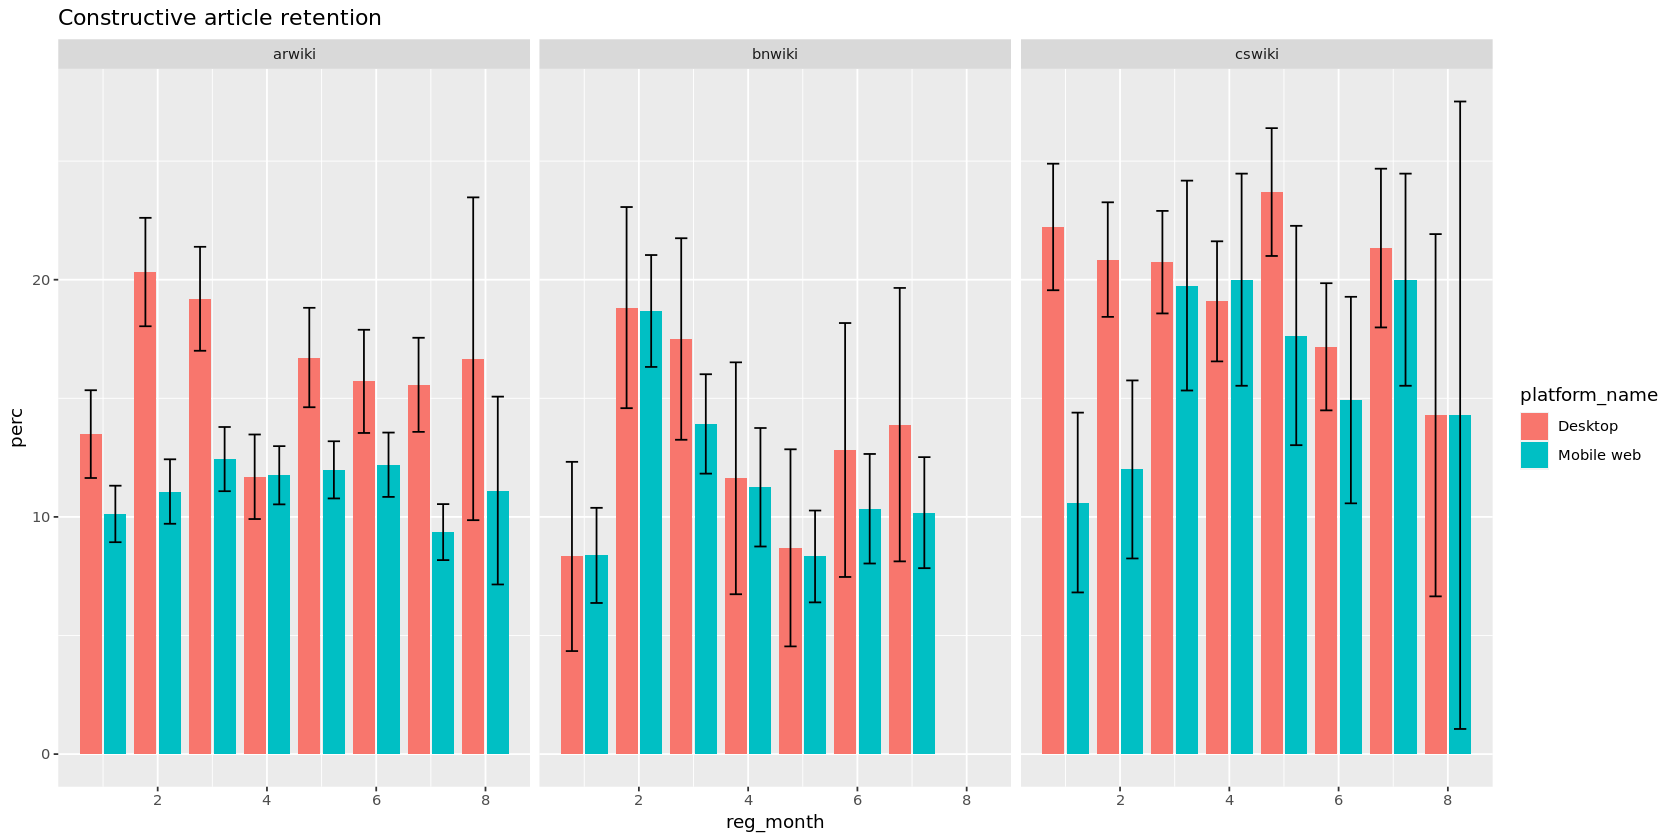

In [31]:
editing_data |>
    mutate(reg_month = as.integer(substr(user_registration, 5, 6))) |>
    filter(is_const_activated_article == TRUE) |>
    group_by(reg_month, wiki_db, platform_name, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = reg_month, y = perc, fill = platform_name)) +
        labs(title = 'Constructive article retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
    facet_grid(. ~ wiki_db)

We can see that there are large differences in retention by month for some of the wikis and some of the platforms.

* Arabic mobile web registrations are fairly consistent across time.
* Czech desktop registrations are also fairly consistent across time.
* Bangla has a spike in February and March that isn't seen anywhere else.
* Arabic desktop varies a lot, with lows in January and April.
* Czech mobile web also varies a lot, low in January and February.

Do we see similar variation in activation? If so, we can use that as control, no?

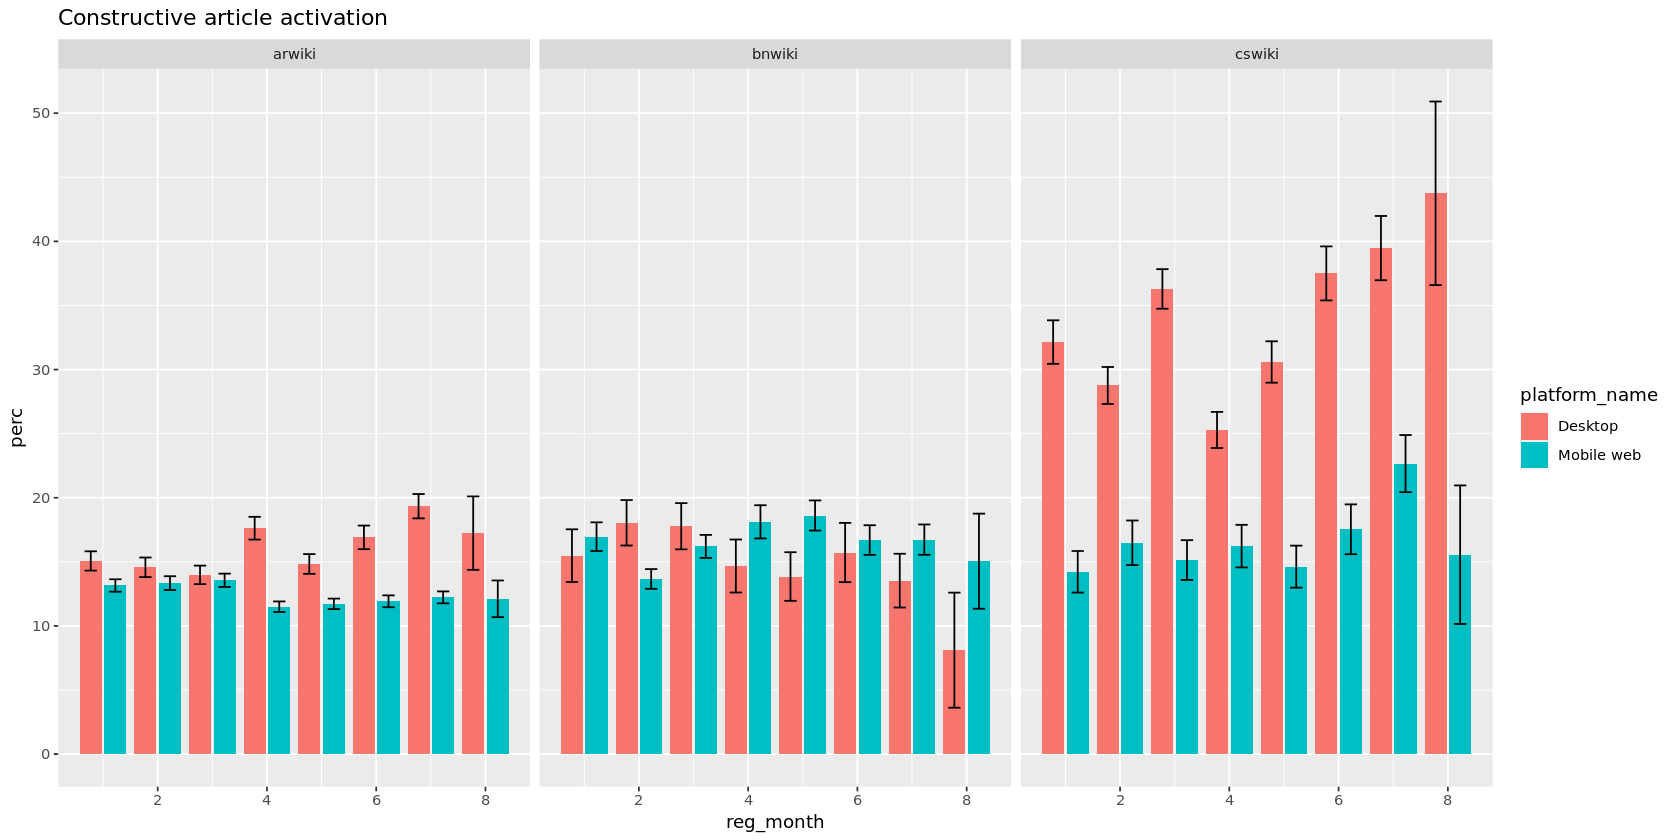

In [32]:
editing_data |>
    mutate(reg_month = as.integer(substr(user_registration, 5, 6))) |>
    group_by(reg_month, wiki_db, platform_name, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = reg_month, y = perc, fill = platform_name)) +
        labs(title = 'Constructive article activation') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
    facet_grid(. ~ wiki_db)

In [9]:
editing_data %>%
    filter(is_const_activated_article == TRUE) |>
    group_by(wiki_db, platform_name, exp_group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform_name, y = perc, fill = exp_group)) +
        labs(title = 'Constructive article retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5)) +
        facet_grid(. ~ wiki_db)

# Regression models

Methodological notes: In previous analyses, we would model retention using the entire dataset and add activation and first day activity as control variables, and then have group assignment as our key explanatory variable. This makes sense, because in that context the randomization happens at registration and we are doing an intent-to-treat analysis.

In this analysis, there is no random assignment. Well, technically, we were running both the New Impact and Levelling Up experiments during this period. However, we're not looking at random assignment in the dataset. Secondly, it is safe to assume that newcomer who are eligible for personalized praise are the more active ones. Or in other words, those who activated. We can therefore switch our approach to only model using newcomers who activated.

## Overall retention

In [34]:
blas_set_num_threads(16)
overall.retention.model.1 <- editing_data |>
    filter(is_activated == TRUE) |>
    glmer(
        formula = is_retained ~ platform + exp_group + log_num_edits_24hrs + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [35]:
summary(overall.retention.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + exp_group + log_num_edits_24hrs + (1 |  
    wiki_db)
   Data: filter(editing_data, is_activated == TRUE)

     AIC      BIC   logLik deviance df.resid 
   16607    16647    -8299    16597    22389 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.218 -0.398 -0.338 -0.268  3.910 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0132   0.115   
Number of obs: 22394, groups:  wiki_db, 3

Fixed effects:
                             Estimate Std. Error z value            Pr(>|z|)
(Intercept)                   -2.8620     0.0876  -32.68 <0.0000000000000002
platformmobile                -0.4712     0.0438  -10.76 <0.0000000000000002
exp_grouppersonalised_praise  -0.0662     0.0405   -1.63                 0.1
log_num_edits_24hrs            1.1403     0.0323   35.27 <0.0000000000000002
              

In [36]:
blas_set_num_threads(16)
overall.retention.model.2 <- editing_data |>
    filter(is_activated == TRUE) |>
    glmer(
        formula = is_retained ~ platform + exp_group + log_num_edits_24hrs +
                    (1 + platform | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see help('isSingular')



In [ ]:
summary(overall.retention.model.2)

Finding that this model is singular and will be discarded is not surprising. We also saw something similar when looking at long-term retention for Newcomer Tasks. Or in other words: platform differences in retention are short-term.

In [37]:
blas_set_num_threads(16)
overall.retention.model.3 <- editing_data |>
    mutate(reg_month = factor(as.integer(substr(user_registration, 5, 6)))) |>
    filter(is_activated == TRUE) |>
    glmer(
        formula = is_retained ~ platform + exp_group + log_num_edits_24hrs + reg_month +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [ ]:
summary(overall.retention.model.3)

This model did have some months that were significantly higher than the baseline (which was month 1, meaning January). However, neither the AIC nor the BIC showed any improvement. We therefore discard this model too.

Let's instead try some approaches that treat time as linear and non-linear functions.

In [40]:
blas_set_num_threads(16)
overall.retention.model.4 <- editing_data |>
    mutate(reg_month = as.integer(substr(user_registration, 5, 6))) |>
    filter(is_activated == TRUE) |>
    glmer(
        formula = is_retained ~ platform + exp_group + log_num_edits_24hrs + reg_month +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [41]:
summary(overall.retention.model.4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained ~ platform + exp_group + log_num_edits_24hrs + reg_month +  
    (1 | wiki_db)
   Data: 
filter(mutate(editing_data, reg_month = as.integer(substr(user_registration,  
    5, 6))), is_activated == TRUE)

     AIC      BIC   logLik deviance df.resid 
   16604    16652    -8296    16592    22388 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.134 -0.394 -0.332 -0.265  4.048 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0135   0.116   
Number of obs: 22394, groups:  wiki_db, 3

Fixed effects:
                             Estimate Std. Error z value            Pr(>|z|)
(Intercept)                   -2.9526     0.0977  -30.23 <0.0000000000000002
platformmobile                -0.4708     0.0438  -10.75 <0.0000000000000002
exp_grouppersonalised_praise  -0.2134     0.0788   -2.71              0.0068
log_nu

In [42]:
blas_set_num_threads(16)
overall.retention.model.5 <- editing_data |>
    mutate(reg_month = as.integer(substr(user_registration, 5, 6))) |>
    filter(is_activated == TRUE) |>
    glmer(
        formula = is_retained ~ platform + exp_group + log_num_edits_24hrs + poly(reg_month, 2) +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [46]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(overall.retention.model.5, c("theta", "fixef"))
blas_set_num_threads(16)
overall.retention.model.5 = update(overall.retention.model.5, start = start_vals,
                             control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [47]:
summary(overall.retention.model.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_retained ~ platform + exp_group + log_num_edits_24hrs + poly(reg_month,  
    2) + (1 | wiki_db)
   Data: 
filter(mutate(editing_data, reg_month = as.integer(substr(user_registration,  
    5, 6))), is_activated == TRUE)
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   16605    16661    -8296    16591    22387 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.077 -0.397 -0.331 -0.267  4.022 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0135   0.116   
Number of obs: 22394, groups:  wiki_db, 3

Fixed effects:
                             Estimate Std. Error z value             Pr(>|z|)
(Intercept)                   -2.7764     0.0893  -31.09 < 0.0000000000000002
platformmobile                -0.4705     0.0438  -10.74 < 0.0000000000000002
exp_grouppersonal

In [45]:
blas_set_num_threads(16)
overall.retention.model.6 <- editing_data |>
    mutate(reg_month = as.integer(substr(user_registration, 5, 6))) |>
    filter(is_activated == TRUE) |>
    glmer(
        formula = is_retained ~ platform + exp_group + log_num_edits_24hrs + poly(reg_month, 3) +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [48]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(overall.retention.model.6, c("theta", "fixef"))
blas_set_num_threads(16)
overall.retention.model.6 = update(overall.retention.model.6, start = start_vals,
                             control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [ ]:
summary(overall.retention.model.6)

## NEXT UP

After reading up on some regression discontinuity work, for example [this paper about the COVID-19 lockdown](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7703221/), I'm interested in doing something similar. It would entail having a variable for the number of days relative to deployment, and have an interaction between that and the experiment group.

Notice also their difference-in-differences approach, of using the two days around the event (deployment in our case), and comparing that to the same two days the year prior. We can grab data for that.

Lastly, I'm curious to know the number of edits a newcomer has made at the time they get praise. Are there trends there, is it a threshold? If so, we can make more direct comparisons.

# Difference-in-Differences Analysis

A DiD analysis is a 2x2 comparison based on time and treatment, and it includes the interaction effect between them. We therefore need to import the 2022 dataset, add a `reg_year` variable. We'll then also limit the dataset to shorter time frames, basically reducing the horizon similar to what is done in a Regression Discontinuity Design. We also need to label the 2022 data similarly as the 2023 data with the same "control" and "personalised_praise" groups.

Step 1: Update the data from 2022 so that users are labelled `control` and `personalised_praise` based on the same timestamp as the 2023 data.

In [117]:
## Time of deployment, used to define a newcomer as "control" or "PP"
deployment_ts = ymd_hms('2023-05-04 08:04:47')
comp2022_deployment_ts = ymd_hms('2022-05-04 08:04:47')
comp2018_deployment_ts = ymd_hms('2018-05-04 08:04:47')

In [96]:
editing_data <- editing_data |>
    mutate(
        user_reg_ts = ymd_hms(user_registration)
    )

In [118]:
comp2018_editing_data <- comp2018_editing_data |>
    mutate(
        user_reg_ts = ymd_hms(user_registration),
        exp_group = ifelse(
            user_reg_ts < comp2018_deployment_ts,
            'control',
            'personalised_praise'
        )
    )

In [91]:
comp2022_editing_data <- comp2022_editing_data |>
    mutate(
        user_reg_ts = ymd_hms(user_registration),
        exp_group = ifelse(
            user_reg_ts < comp2022_deployment_ts,
            'control',
            'personalised_praise'
        )
    )

In [119]:
## We need to do this without messing up the factor for existing data.

full_editing_data <- rbind(editing_data, comp2018_editing_data, comp2022_editing_data)

Step 2: Update the dataset so that it has a `reg_year` variable.

In [125]:
full_editing_data <- full_editing_data |>
    mutate(
        reg_year = factor(as.character(year(user_reg_ts)), levels = c('2018', '2022', '2023'))
    )

Step 3: Define a limited time period for both datasets. We exclude the time period between first deployment and final deployment (May 4 to May 24). For simplicity, we'll compare March to June, and limit March to a 30-day month to match up with the number of days in June. We'll start by looking at retention based on our standard metrics, then move over to look at total edits made.

In [ ]:
full_editing_data |>
    filter(
        (reg_year != 2018) &
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30)
    ) |>
    select(user_registration_ts) |>
    summary()

This looks good! We'll then feed that to your regression model.

In [ ]:
full_editing_data |>
    select(user_reg_ts, exp_group)

In [122]:
did.retention.model.1 <- full_editing_data |>
    filter(
        (reg_year != 2018) &
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE)
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

In [123]:
summary(did.retention.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(full_editing_data, (reg_year != 2018) & (month(user_reg_ts) ==  
    3 | month(user_reg_ts) == 6) & (day(user_reg_ts) <= 30) &  
    (is_activated == TRUE))

     AIC      BIC   logLik deviance df.resid 
    9010     9062    -4498     8996    11975 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.632 -0.395 -0.334 -0.265  4.000 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0036   0.06    
Number of obs: 11982, groups:  wiki_db, 3

Fixed effects:
                                          Estimate Std. Error z value
(Intercept)                               -2.84977    0.09236  -30.85
platformmobile                            -0.50741    0.05664   -8.96
exp_grouppersonalised_praise              -0.15139    0.0

## NEXT UP

* Interpret these findings, looks like there's not a significant change in retention.
* Gather a dataset from 2019 as a validity check.
* Consider switching to a threshold-based approach for understanding the effect, basically that we're looking at pre/post qualifying for praise (e.g. nobody below 8 edits got praised).

# Validity Checks and Other Approaches

## Adding a filter

We saw in our analysis of number of edits a user has to make before they're praised that we can use 8 as a threshold. This is expected because the mentors set an activity threshold in their preferences (or use the default). We therefore choose to focus on users who make at least 8 edits in the first 30 days in order to compare users who are more likely to be eligible to be praised.

In [107]:
did.retention.model.2 <- full_editing_data |>
    filter(
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE) &
        (num_total_edits > 7)
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

In [108]:
summary(did.retention.model.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: 
filter(full_editing_data, (month(user_reg_ts) == 3 | month(user_reg_ts) ==  
    6) & (day(user_reg_ts) <= 30) & (is_activated == TRUE) &  
    (num_total_edits > 7))

     AIC      BIC   logLik deviance df.resid 
    1227     1262     -606     1213     1111 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.741 -1.000  0.363  0.671  4.398 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.000831 0.0288  
Number of obs: 1118, groups:  wiki_db, 3

Fixed effects:
                                          Estimate Std. Error z value
(Intercept)                                 4.3410     0.3354   12.94
platformmobile                             -0.0989     0.1479   -0.67
exp_grouppersonalised_praise               -0.5824    

So it looks like there's possibly an increase in retention for more active newcomers.

## Comparison with 2018 data

Instead of using 2022 as the baseline, we use 2018.

In [126]:
did.retention.model.2018 <- full_editing_data |>
    filter(
        (reg_year != 2022) &
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE)
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

boundary (singular) fit: see help('isSingular')



This model is singular, so we switch from a mixed-effects model to a straight logistic regression.

In [127]:
did.retention.model.2018 <- full_editing_data |>
    filter(
        (reg_year != 2022) &
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE)
    ) |>
    glm(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs,
        family = binomial(link = "logit"))

In [128]:
summary(did.retention.model.2018)


Call:
glm(formula = is_retained ~ platform + exp_group * reg_year + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(full_editing_data, 
    (reg_year != 2022) & (month(user_reg_ts) == 3 | month(user_reg_ts) == 
        6) & (day(user_reg_ts) <= 30) & (is_activated == TRUE)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.342  -0.540  -0.450  -0.368   2.357  

Coefficients:
                                          Estimate Std. Error z value
(Intercept)                                -2.9735     0.0811  -36.66
platformmobile                             -0.4298     0.0555   -7.75
exp_grouppersonalised_praise               -0.1149     0.0801   -1.43
reg_year2023                                0.1025     0.0726    1.41
log_num_edits_24hrs                         1.1625     0.0435   26.73
exp_grouppersonalised_praise:reg_year2023  -0.0486     0.1117   -0.44
                                                      Pr(>|z|)    
(Intercept)         

We again find no significant difference. Similarly as we did for the other dataset, we filter it to users with more than 7 edits.

In [129]:
did.retention.model.2018.2 <- full_editing_data |>
    filter(
        (reg_year != 2022) &
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE) &
        (num_total_edits > 7)
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

boundary (singular) fit: see help('isSingular')



In [130]:
did.retention.model.2018.2 <- full_editing_data |>
    filter(
        (reg_year != 2022) &
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs,
        family = binomial(link = "logit"))

In [131]:
summary(did.retention.model.2018.2)


Call:
glm(formula = is_retained ~ platform + exp_group * reg_year + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(full_editing_data, 
    (reg_year != 2022) & (month(user_reg_ts) == 3 | month(user_reg_ts) == 
        6) & (day(user_reg_ts) <= 30) & (is_activated == TRUE) & 
        (num_total_edits > 7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.688  -1.185   0.525   0.837   2.431  

Coefficients:
                                          Estimate Std. Error z value
(Intercept)                                 4.1963     0.3312   12.67
platformmobile                             -0.0612     0.1444   -0.42
exp_grouppersonalised_praise               -0.3599     0.2112   -1.70
reg_year2023                               -0.3859     0.1973   -1.96
log_num_edits_24hrs                        -1.3872     0.1181  -11.75
exp_grouppersonalised_praise:reg_year2023   0.4011     0.2882    1.39
                                                     P

The effect is not significant in this dataset, but it is still leaning positive. Let's compare 2018 to 2022 as well.

In [132]:
did.retention.model.2018.3 <- full_editing_data |>
    filter(
        (reg_year != 2023) &
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE)
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

In [133]:
summary(did.retention.model.2018.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(full_editing_data, (reg_year != 2023) & (month(user_reg_ts) ==  
    3 | month(user_reg_ts) == 6) & (day(user_reg_ts) <= 30) &  
    (is_activated == TRUE))

     AIC      BIC   logLik deviance df.resid 
    8783     8835    -4384     8769    11947 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.863 -0.389 -0.327 -0.270  4.122 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.00633  0.0796  
Number of obs: 11954, groups:  wiki_db, 3

Fixed effects:
                                          Estimate Std. Error z value
(Intercept)                                -3.0056     0.0984  -30.56
platformmobile                             -0.4619     0.0575   -8.04
exp_grouppersonalised_praise               -0.1156     0.

In [134]:
did.retention.model.2018.4 <- full_editing_data |>
    filter(
        (reg_year != 2023) &
        (month(user_reg_ts) == 3 | month(user_reg_ts) == 6) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE) & 
        (num_total_edits > 7)
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

In [135]:
summary(did.retention.model.2018.4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(full_editing_data, (reg_year != 2023) & (month(user_reg_ts) ==  
    3 | month(user_reg_ts) == 6) & (day(user_reg_ts) <= 30) &  
    (is_activated == TRUE) & (num_total_edits > 7))

     AIC      BIC   logLik deviance df.resid 
    1132     1167     -559     1118     1059 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.894 -0.909  0.338  0.641  5.014 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0197   0.14    
Number of obs: 1066, groups:  wiki_db, 3

Fixed effects:
                                          Estimate Std. Error z value
(Intercept)                                 4.4930     0.3663   12.27
platformmobile                             -0.1479     0.1556   -0.95
exp_grouppersonalised_praise      

As we'd expect, 2018 and 2022 are not significantly different from each other.

One thing to note is that Arabic Wikipedia has way more registrations in 2018 than it did in the later years. There might be differences in the community that are worth thinking about.

## Equal Trends Assumption Check

We can compare the 2022 and 2023 data by comparing January, February, and March, because they should *not* have been affected by the intervention. If we see similar numbers in retention for those three months, then the differences should come from the intervention (or whatever else happened in 2023).

In [152]:
full_editing_data |>
    filter(reg_year != 2018) |>
    mutate(reg_month = as.integer(substr(user_registration, 5, 6))) |>
    group_by(reg_year, reg_month, wiki_db, platform_name, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = reg_month, y = perc, fill = reg_year)) +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        labs(title = 'Constructive article activation') +
#        geom_col(position = 'dodge2') + 
        geom_line(aes(colour = reg_year)) +
        geom_vline(xintercept = 3, linetype = 2) +
        geom_vline(xintercept = 6, linetype = 2) +
    facet_grid(platform_name ~ wiki_db)    

It's difficult to tell whether these differences suggest that these are not comparable. In my opinion, they seem to be reasonably stable, meaning that we could use any of the first four months as comparisons.

What if we only look at the more active users?

In [153]:
full_editing_data |>
    filter(
        (reg_year != 2018) &
        (num_total_edits > 7)
    ) |>
    mutate(reg_month = as.integer(substr(user_registration, 5, 6))) |>
    group_by(reg_year, reg_month, wiki_db, platform_name, is_const_activated_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_activated_article == TRUE) %>%
    ggplot(aes(x = reg_month, y = perc, fill = reg_year)) +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        labs(title = 'Constructive article activation') +
#        geom_col(position = 'dodge2') + 
        geom_line(aes(colour = reg_year)) +
        geom_vline(xintercept = 3, linetype = 2) +
        geom_vline(xintercept = 6, linetype = 2) +
    facet_grid(platform_name ~ wiki_db)    

Here we see a lot more variation. I still think using March and June are reasonable. Once we have data from Spanish, which is a real A/B test, we can see if things hold up.

### Using a longer timeframe

We only compare a single month with a single month. What if we compare Jan–Mar with May onwards?

In [163]:
did.longer.retention.model.1 <- full_editing_data |>
    filter(
        (reg_year != 2018) &
        (month(user_reg_ts) <= 3 | month(user_reg_ts) >= 5) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE)
    ) |>
    glmer(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

In [164]:
summary(did.longer.retention.model.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: filter(full_editing_data, (reg_year != 2018) & (month(user_reg_ts) <=  
    3 | month(user_reg_ts) >= 5) & (day(user_reg_ts) <= 30) &  
    (is_activated == TRUE))

     AIC      BIC   logLik deviance df.resid 
   27053    27113   -13520    27039    35973 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.428 -0.403 -0.342 -0.275  3.824 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.00328  0.0572  
Number of obs: 35980, groups:  wiki_db, 3

Fixed effects:
                                          Estimate Std. Error z value
(Intercept)                               -2.82788    0.05942  -47.59
platformmobile                            -0.49593    0.03431  -14.46
exp_grouppersonalised_praise              -0.06005    0.0

In [167]:
did.longer.retention.model.2 <- full_editing_data |>
    filter(
        (reg_year != 2018) &
        (month(user_reg_ts) <= 3 | month(user_reg_ts) >= 5) &
        (day(user_reg_ts) <= 30) &
        (is_const_activated_article == TRUE)
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group * reg_year + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

In [168]:
summary(did.longer.retention.model.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ platform + exp_group * reg_year +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: filter(full_editing_data, (reg_year != 2018) & (month(user_reg_ts) <=  
    3 | month(user_reg_ts) >= 5) & (day(user_reg_ts) <= 30) &  
    (is_const_activated_article == TRUE))

     AIC      BIC   logLik deviance df.resid 
   13532    13587    -6759    13518    18014 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.742 -0.380 -0.337 -0.275  3.720 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.00629  0.0793  
Number of obs: 18021, groups:  wiki_db, 3

Fixed effects:
                                          Estimate Std. Error z value
(Intercept)                                -2.9131     0.0816  -35.72
platformmobile                             -0.4091     0.0488   -8.38
exp_groupperson

In [170]:
did.longer.retention.model.3 <- full_editing_data |>
    filter(
        (reg_year != 2018) &
        (month(user_reg_ts) <= 3 | month(user_reg_ts) >= 5) &
        (day(user_reg_ts) <= 30) &
        (is_activated == TRUE) &
        (num_total_edits > 7)
    ) |>
    glm(
        formula = is_retained ~ platform + exp_group * reg_year + log_num_edits_24hrs,
        family = binomial(link = "logit"))

In [171]:
summary(did.longer.retention.model.3)


Call:
glm(formula = is_retained ~ platform + exp_group * reg_year + 
    log_num_edits_24hrs, family = binomial(link = "logit"), data = filter(full_editing_data, 
    (reg_year != 2018) & (month(user_reg_ts) <= 3 | month(user_reg_ts) >= 
        5) & (day(user_reg_ts) <= 30) & (is_activated == TRUE) & 
        (num_total_edits > 7)))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.687  -1.159   0.465   0.819   2.278  

Coefficients:
                                          Estimate Std. Error z value
(Intercept)                                 4.3591     0.1966   22.17
platformmobile                             -0.3990     0.0850   -4.70
exp_grouppersonalised_praise               -0.1622     0.1212   -1.34
reg_year2023                               -0.1469     0.1173   -1.25
log_num_edits_24hrs                        -1.4617     0.0727  -20.11
exp_grouppersonalised_praise:reg_year2023   0.1739     0.1667    1.04
                                                      

In [172]:
did.longer.retention.model.4 <- full_editing_data |>
    filter(
        (reg_year != 2018) &
        (month(user_reg_ts) <= 3 | month(user_reg_ts) >= 5) &
        (day(user_reg_ts) <= 30) &
        (is_const_activated_article == TRUE) &
        (num_total_edits > 7)
    ) |>
    glmer(
        formula = is_const_retained_article ~ platform + exp_group * reg_year + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))

In [173]:
summary(did.longer.retention.model.4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ platform + exp_group * reg_year +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: filter(full_editing_data, (reg_year != 2018) & (month(user_reg_ts) <=  
    3 | month(user_reg_ts) >= 5) & (day(user_reg_ts) <= 30) &  
    (is_const_activated_article == TRUE) & (num_total_edits >      7))

     AIC      BIC   logLik deviance df.resid 
    3168     3208    -1577     3154     2396 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.009 -1.073  0.634  0.819  1.535 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0301   0.174   
Number of obs: 2403, groups:  wiki_db, 3

Fixed effects:
                                          Estimate Std. Error z value
(Intercept)                                1.44637    0.17686    8.18
platformmobile                            -0.40377    0.0